In [1]:
%%R
library(reticulate)
use_condaenv('ethique_env')

UsageError: Cell magic `%%R` not found.


In [2]:
%%capture
%run ./german.ipynb

# Privacy

Dans ce notebook je vais présenter les différentes attaques présentées dans la trousse à outils d'IMB *Adversarial Robusteness 360* :

 - Evasion
 - Poisoning
 - Inference and Inversion
 - Model Extraction
 
Pour illustrer ces différentes attaques nous allons utilisé la base de données : 

 - German Credit (lien)
 
Le modèle que nous allons attaquer est une régression logisitique en utilisant la librairie *scikit learn* 

In [3]:
import numpy as np

from tqdm import tqdm

from copy import deepcopy
from itertools import combinations, product
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set_theme(style='darkgrid')

# Il est difficile de protéger efficacement ses assets (modèle/base de données)

## Définition de *privacy* / enjeux économique

## Description générale des différentes attaques et implémentation 

### Model extraction

Le but de cette attaque est de réccupérer les poids d'un modèle.
On suppose que l'on connait l'architechure : regression logistique.

Ce que l'on va faire c'est créer des nouvelles entrées que l'on va donné à notre modèle blackbox qui va les labélisé puis on va utilser ces labels pour entrainer notre nouveau modèle.

In [4]:
def new_entries(n):
    list_entries = []
    for col in X.columns:
        list_entries.append(np.random.choice(X[col].unique(), n, p=(X[col].value_counts(normalize=True)).to_numpy()))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [5]:
n = len(X_train)
X_new = new_entries(n)
y_new = logreg.predict(X_new)

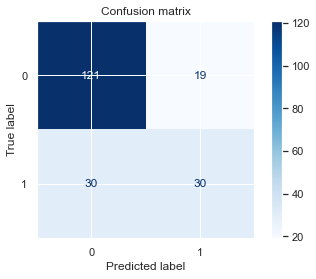

Sensitivity  Specificity   Precision     Accuracy  
    0.86         0.50         0.61         0.76    


In [6]:
mesure_clas(model.fit(X_train, y_train), X_test, y_test)

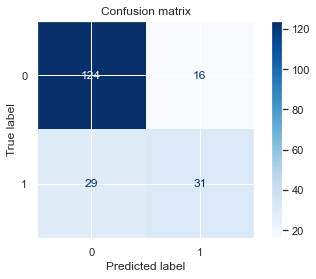

Sensitivity  Specificity   Precision     Accuracy  
    0.89         0.52         0.66         0.78    


In [7]:
mesure_clas(model.fit(X_new, y_new), X_test, y_test)

In [8]:
def new_entries_unif(n):
    list_entries = []
    for col in X.columns:
        list_entries.append(np.random.choice(X[col].unique(), n))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [9]:
n = len(X_train)
X_new_unif = new_entries_unif(n)
logreg = model.fit(X_train, y_train)
y_new_unif = logreg.predict(X_new_unif)

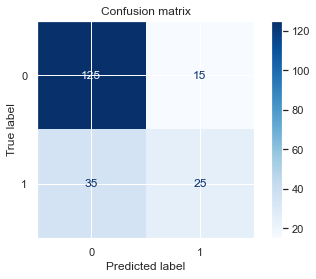

Sensitivity  Specificity   Precision     Accuracy  
    0.89         0.42         0.62         0.75    


In [10]:
mesure_clas(model.fit(X_new_unif, y_new_unif), X_test, y_test)

Mesure de distance :
 - l'accuracy : mesure de l'efficacité de l'apprentissage
 - la précision : mesure de la distance du modèle original

In [11]:
y_hat = model.fit(X_new, y_new).predict(X_test)
y_ori = model.fit(X_train, y_train).predict(X_test)

prec = (y_ori == y_hat).astype(int).sum()/len(y_ori)
accu_diff = accuracy_score(y_test, y_ori) - accuracy_score(y_test, y_hat)
print(f"Précision : {prec:.3f}, Différence d'accuracy : {accu_diff:.3f}")

Précision : 0.900, Différence d'accuracy : -0.020


In [12]:
y_hat = model.fit(X_new_unif, y_new_unif).predict(X_test)
y_ori = model.fit(X_train, y_train).predict(X_test)

prec = (y_ori == y_hat).astype(int).sum()/len(y_ori)
accu_diff = accuracy_score(y_test, y_ori) - accuracy_score(y_test, y_hat)
print(f"Précision : {prec:.3f}, Différence d'accuracy : {accu_diff:.3f}")

Précision : 0.925, Différence d'accuracy : 0.005


### Trouver un modèle capable de surapprendre

In [13]:
def add_relations(df_orig):
    df = df_orig.copy()
    for i, j in combinations(cat_variables, 2):
        df[i + j] = df[i] + df[j]
    return df

new_cat_variables = cat_variables + [i + j for i, j in combinations(cat_variables, 2)]


# On normalise les colones dans leur noms
all_values = [X[col].unique() for col in cat_variables]
categorie_rel = list(combinations(all_values, 2))

categorie_name = [a + b for a,b in combinations(cat_variables, 2)]
categorie_values = [[a + b for a,b in list(product(*x))] for x in categorie_rel]

preprocessor_comb = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories=all_values+categorie_values, drop='first', sparse=False), 
         new_cat_variables),
        ('ord', StandardScaler(), ord_variables)
    ])

model_over = Pipeline(
    steps=[
        ('relations', FunctionTransformer(add_relations)), 
        ('preprocession', preprocessor_comb),
        ('logreg', LogisticRegression(max_iter=200))
    ]
)

In [14]:
#%timeit model.fit(X_train, y_train)
#print(f"validation : {model.score(X_test, y_test):.3f}, score : {model.score(X_train, y_train):.3f}") 

print("""39.1 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
validation : 0.735, score : 0.787""")

39.1 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
validation : 0.735, score : 0.787


In [15]:
#%timeit model_over.fit(X_train, y_train)
#print(f"validation : {model_over.score(X_test, y_test):.3f}, score : {model_over.score(X_train, y_train):.3f}") 

print("""216 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
validation : 0.725, score : 0.958""")

216 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
validation : 0.725, score : 0.958


On a donc de l'overfit 

### Proprety inference

On va chercher a reccupérer la proportion homme/femme de la base de donnée d'entrainement

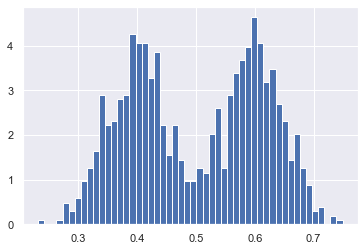

In [16]:
dist = np.random.normal(np.random.choice([0.4, 0.6], size=1000), scale=0.05)
plt.hist(dist, density=True, bins=50)
plt.show()

In [17]:
def new_entries_homme(n, prop=False):
    list_entries = []
    for col in X.columns:
        if col == 'sex':
            q = np.clip(np.random.normal(np.random.choice([0.4, 0.6]), scale=0.05), 0, 1)
            list_entries.append(np.random.choice(['male', 'female'], n, p=[q, 1-q]))
        else:
            if prop:
                list_entries.append(np.random.choice(X[col].unique(), n, p=(X[col].value_counts(normalize=True)).to_numpy()))
            else:
                list_entries.append(np.random.choice(X[col].unique(), n))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [18]:
new_entries_homme(1000).sex.value_counts(normalize=True)

female    0.632
male      0.368
Name: sex, dtype: float64

On se place dans le cas suivant :

On a un modèle *model_secret* qui à la structure de *model_chose* et qui est entrainé sur une base de données : *X_train_secret*, et une labélisation : *y_train_secret*.
On cherche à savoir si la base de données secrète avait une majorité d'homme.

Pour se faire on va procéder de la manière suivante :

Comme on n'a pas accès à la base de données *X_train_secret* on va devoir créer une liste de bases : *list_data_X* qui est une liste de base générée avec la fonction : *new_entries_homme* qui génére de nouvelles entrées uniformément pour toutes les variables sauf *sex* où la proportion d'hommes est tirée selon une normale centré en 0,6 ou 0,4 et de écart type 0,05.
On utilise le modèle *model_secret* pour labéliser les nouvelles entrées que l'on garde dans la variable *liste_data_y*. (étape de *model extraction*)

Pour chaque nouvelle base de données on entraine un modèle de la structure *model_choisi* et on récupère les poids de ce modèle.
Tous ces poids forme la base *data_meta_X*. C'est une base de données où chaque entrée $i$ coorespond aux coefficients du modèle entrainé sur *(list_data_X[i], list\_data\_y[i])*.

On crée la labélisation de notre méta-modèle *data_meta_y* en notant $1$ s'il y a plus d'homme que de femme dans le base de données *list_data_X[i]* et 0 sinon.

On va entrainer notre méta-modèle qui est une régression logstique sur *(data_meta_X, data_meta_y)*

On va finalement donner les coefficients de notre modèle secret à notre méta-modèle et il va nous dire si le modèle secret a été entrainé sur une base de données avec une majoritée d'homme (1) ou de femme (0). 

*FAIRE UN SCHÉMA*

In [19]:
n_data = 300
n_entries = len(X_train)

X_train_secret = X_train
y_train_secret = y_train

prop = False
new = False
# Choisir si on veut utiliser le modèle qui surapprend ou pas 
model_choisi = model  #model
name = '_overfit' if model_choisi == model_over else ''
prop_name = '_prop' if prop else '_unif'

model_secret = deepcopy(model_choisi.fit(X_train_secret, y_train_secret))

if new:
    list_data_X = [new_entries_homme(n_entries, prop) for _ in tqdm(range(n_data))]
    dist_homme = np.array([(x.sex.value_counts(normalize=True))['male'] for x in list_data_X])
    
    list_data_y = model_secret.predict(pd.DataFrame(np.array(list_data_X).reshape(-1, 21), 
                                               columns=X.columns)).reshape(n_data, -1)

    data_meta_X = [model_choisi.fit(list_data_X[i], list_data_y[i])['logreg'].coef_[0] 
                       for i in tqdm(range(len(list_data_X)))]
    
    np.savez_compressed(f'data/privacy/data{name}{prop_name}.npz', 
                        data_meta=data_meta_X, 
                        list_homme=dist_homme)
else:
    file = np.load(f'data/privacy/data{name}{prop_name}.npz', allow_pickle=True)
    data_meta_X = file['data_meta']
    dist_homme = file['dist_homme']
    
data_meta_y = (dist_homme > 0.5).astype('int')

#### Visualisation de la répartition de la proportion d'hommes dans les bases de données

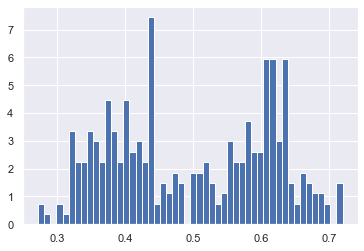

In [20]:
plt.hist(dist_homme, density=True, bins=50)
plt.show()

#### Entrainement du méta-modèle

In [21]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = model_selection.train_test_split(data_meta_X, 
                                                                                        data_meta_y, 
                                                                                        test_size=0.20)
meta_model = LogisticRegression(max_iter=200)
meta_model.fit(X_train_meta, y_train_meta)

LogisticRegression(max_iter=200)

In [22]:
confusion_matrix(y_test_meta, meta_model.predict(X_test_meta))

array([[16, 13],
       [17, 14]])

100%|██████████| 100/100 [00:02<00:00, 44.86it/s]


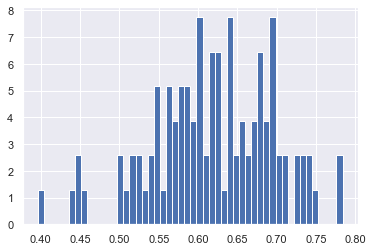

In [23]:
l = []
X_train_meta_all, X_test_meta_all, y_train_meta_all, y_test_meta_all = model_selection.train_test_split(data_meta_X, 
                                                                                        data_meta_y, 
                                                                                        test_size=0.01)
for i in tqdm(range(100)):
    X_train_meta, _, y_train_meta, _ = model_selection.train_test_split(X_train_meta_all, 
                                                                        y_train_meta_all, 
                                                                        test_size=0.20)
    meta_model = LogisticRegression(max_iter=200)
    meta_model.fit(X_train_meta, y_train_meta)
    
    #l += [meta_model.predict_proba(model_secret['logreg'].coef_)[0,1]]
    l += [meta_model.predict_proba([X_test_meta[0]])[0,1]]

plt.hist(l, density=True, bins=50, color='b')
plt.show()

In [24]:
print(y_test_meta[0])

1


#### Régression linéaire pour trouver le proportion d'homme

In [25]:
data_meta_y_linear = dist_homme
X_train_meta, X_test_meta, y_train_meta, y_test_meta = model_selection.train_test_split(data_meta_X, 
                                                                                        data_meta_y_linear, 
                                                                                        test_size=0.20, 
                                                                                        random_state=seed)

In [26]:
meta_model_linear = LinearRegression()
meta_model_linear.fit(X_train_meta, y_train_meta)

LinearRegression()

On regarde la différence moyenne en pourcentage entre la prévision du modèle et la réalité

In [27]:
((np.abs(y_test_meta - meta_model_linear.predict(X_test_meta))/y_test_meta) * 100).mean()

24.322101347546102

In [28]:
meta_model_linear.predict(model_secret['logreg'].coef_)

array([-0.00056166])

In [29]:
from sklearn import svm

meta_model_svr = svm.LinearSVR(max_iter=100000)
meta_model_svr.fit(X_train_meta, y_train_meta)

LinearSVR(max_iter=100000)

In [30]:
((np.abs(y_test_meta - meta_model_svr.predict(X_test_meta))/y_test_meta) * 100).mean()

26.667265345947172

In [31]:
meta_model_svr.predict(model_secret['logreg'].coef_)

array([0.1598522])

# Mitiger les dégâts

## Présentation du *Differential Privacy*

### Sur la base de données

### Sur le gradient d'apprentissage

## Implémentation et étude de cas

On utilise la librairie *diffprivlib* qui permet d'implémenter avec des modèles de *sklearn* la *differential privacy*.

In [32]:
import diffprivlib.models as diff

In [33]:
epsilon=1
data_norm=1

model_over_diff = Pipeline(
    steps=[
        ('relations', FunctionTransformer(add_relations)), 
        ('preprocession', preprocessor_comb),
        # La seule différence avec model_over
        ('logreg', diff.LogisticRegression(max_iter=200, epsilon=epsilon, data_norm=data_norm))
    ]
)

In [34]:
model_over_diff.fit(X_train, y_train)
print(f"validation : {model_over_diff.score(X_test, y_test):.3f}, score : {model_over_diff.score(X_train, y_train):.3f}") 

validation : 0.445, score : 0.506


C'est là où il y a un problème on ne peut plus vraiment utilisé le modèle secret pour auto-labélisé les nouvelles données car il perd en efficacité donc la labélisation de *y_train_secret* est vraiment différentes de l'auto-labélisation. Il faut donc s'éloigner de la situation initale qui combinait le *proprety inference* et le *model extraction* comme on ne veut que le premier on va suivre le protocole suivant :

 - On va créer un *pool* de données (100000)
 - On utilise le *model_secret* entrainé sur (X_train_secret, y_train_secret) pour auto-labélisé
 - On va tirer une base de données secrete parmis ces données que l'on va renommé *data_secret*
 - La liste de data va être tirée dans la *pool* en tirant le bon nombre d'entrées hommme et femme
 
 - On entraine de la même manière le meta modèle mais cette fois-ci : y_train_secret et le y de list_data_y sont de même forme

### Creation d'un très grand nombre d'entrées


In [35]:
def new_entries_unif_sex(n):
    list_entries = []
    for col in X.columns:
        if col == 'sex':
            list_entries.append(np.random.choice(X[col].unique(), n))
        else:
            list_entries.append(np.random.choice(X[col].unique(), n, p=(X[col].value_counts(normalize=True)).to_numpy()))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [36]:
def index_fix_p_homme(p, N):
    nb_homme = round(p * N) 

    male_index = np.random.choice(all_male_index, replace=False, size=nb_homme)
    female_index = np.random.choice(all_female_index, replace=False, size=N-nb_homme)

    return np.concatenate([male_index, female_index])

In [37]:
N = 800
m = 300

new = False

model_predict = model_over.fit(X_train, y_train)

if new:  
    data_pool = new_entries_unif_sex(100000)
    data_pool['default'] = model_predict.predict(data_pool)
    
    all_male_index = data_pool[data_pool.sex == 'male'].index
    all_female_index = data_pool[data_pool.sex == 'female'].index
        
    all_p = np.clip(np.random.normal(np.random.choice([0.4, 0.6], size=m), scale=0.05), 0, 1)
    sub_index = [index_fix_p_homme(p, N) for p in tqdm(all_p)]
    np.savez_compressed('data/privacy/diff_data.npz', data_pool=np.array(data_pool),
                        sub_index=np.array(sub_index))
else:
    file = np.load('data/privacy/diff_data.npz', allow_pickle=True)
    
    data_pool = pd.DataFrame(file['data_pool'], columns=list(X.columns) + ['default'])
    sub_index = file['sub_index']
    
sub_data = [data_pool.iloc[indexes] for indexes in sub_index]

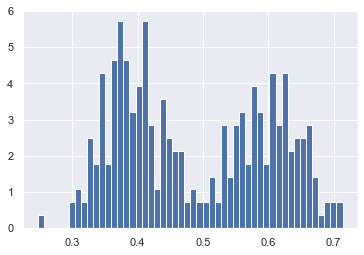

In [38]:
dist_homme = [(x.sex.value_counts(normalize=True))['male'] for x in sub_data]
plt.hist(dist_homme, density=True, bins=50)
plt.show()

In [39]:
new = False

list_data_X = [df.drop('default', axis=1) for df in sub_data]

if new:
    list_data_y = [df.defaut for df in sub_data]

    data_meta_X = [model_over.fit(list_data_X[i], list_data_y[i])['logreg'].coef_[0] 
                        for i in tqdm(range(len(list_data_X)))]

    np.savez_compressed('data/privacy/data_meta_over_prop_diff.npz', data_meta=np.array(data_meta_X))
else:
    data_meta_X = np.load('data/privacy/data_meta_over_prop_diff.npz')['data_meta']
    
    
data_meta_y = np.array([df.sex.value_counts().index[0] == 'male' 
                            for df in list_data_X]).astype('int')

In [40]:
X_open, X_secret, y_open, y_secret = model_selection.train_test_split(data_meta_X, 
                                                                        data_meta_y, 
                                                                        test_size=0.20)

meta_model = LogisticRegression(max_iter=200)
meta_model.fit(X_open, y_open)
confusion_matrix(y_secret, meta_model.predict(X_secret))

array([[15, 14],
       [19, 12]])

In [41]:
data_pool.columns = list(X.columns) + ['default']

In [42]:
all_male_index = data_pool[data_pool.sex == 'male'].index
all_female_index = data_pool[data_pool.sex == 'female'].index

X_secret = data_pool.iloc[index_fix_p_homme(0.6, 1000)].drop(columns=['default'])
y_secret = model_predict.predict(X_secret)
      
X_secret_train, X_secret_test, y_secret_train, y_secret_test = model_selection.train_test_split(X_secret, 
                                                                                                    y_secret, 
                                                                                                    test_size=0.20)

In [43]:
model_over.fit(X_secret_train, y_secret_train)
y_test_pred = model_over.predict(X_secret_test)
cm = confusion_matrix(y_secret_test, y_test_pred)
print(cm)

[[142   4]
 [ 14  40]]


In [44]:
X_secret_train.sex.value_counts(normalize=True)

male      0.605
female    0.395
Name: sex, dtype: float64

In [45]:
meta_model.predict_proba(model_over['logreg'].coef_)

array([[0.93156829, 0.06843171]])

On a donc un meta modèle qui ne dépends plus d'un *model extraction* et qui fonctionne bien.
On va maintenant tracer pour différentes valeurs de *epsilon* et de *data_norm* les valeurs de prédiction du méta model et du recal.

In [46]:
def gen_model_diff(epsilon=1, data_norm=1):
    model = Pipeline(
        steps=[
            ('relations', FunctionTransformer(add_relations)), 
            ('preprocession', preprocessor_comb),
            # La seule différence avec model_over
            ('logreg', diff.LogisticRegression(max_iter=200, epsilon=epsilon, data_norm=data_norm))
        ]
    )
    return model

In [47]:
def mesure(model):
    
    y_test_pred = model.predict(X_test_secret)
    cm = confusion_matrix(y_test_secret, y_test_pred)
    
    pred_homme = meta_model.predict_proba(model['logreg'].coef_)[0,1]
    
    recall = cm[0,0]/(cm[0,0]+cm[1,0])
    specificity = cm[1,1]/(cm[1,1]+cm[0,1])
    precision = cm[0,0]/(cm[0,0]+cm[0,1])
    accuracy =(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
  
    return recall, specificity, precision, accuracy, pred_homme

In [48]:
%%capture --no-display --no-stdout
new = False

columns = ['recall', 'specificity', 'precision', 'accuracy', 'pred_homme', 'eps', 'data_norm']

if new:
    nb_test = 10
    list_eps = np.logspace(-1, 2, 10)
    list_data_norm = np.logspace(-1, 2, 10)
    
    X_secret = data_fix_p_homme(0.6, 1000)
    y_secret = model_predict.predict(X_secret)
    
    X_train_secret, X_test_secret, y_train_secret, y_test_secret = model_selection.train_test_split(X_secret, 
                                                                                                    y_secret, 
                                                                                                    test_size=0.20)
    def mesure(model):
        model.fit(X_train_secret, y_train_secret)
        y_test_pred = model.predict(X_test_secret)
        cm = confusion_matrix(y_test_secret, y_test_pred)

        recall = cm[0,0]/(cm[0,0]+cm[1,0])
        specificity = cm[1,1]/(cm[1,1]+cm[0,1])
        precision = cm[0,0]/(cm[0,0]+cm[0,1])
        accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
        
        pred_homme = meta_model.predict_proba(model['logreg'].coef_)[0,1]

        return recall, specificity, precision, accuracy, pred_homme

    all_mesures = [(*mesure(gen_model_diff(eps, data_norm)), eps, data_norm) for eps in tqdm(list_eps) 
                 for data_norm in list_data_norm 
                     for _ in range(nb_test)]

    df_mesures = pd.DataFrame(all_mesures, columns=columns)
    
    np.save('data/privacy/data_mesures.npy', df_mesures.to_numpy())
else:
    df_mesures = pd.DataFrame(np.load('data/privacy/data_mesures.npy'), columns=columns)

In [49]:
#first_var = 'eps'  #'data_norm'

#df_mesure = df_mesures.dropna()   
        
#second_var = 'data_norm' if first_var == 'eps' else 'eps'   

#list_df_mesure = [group for _, group in df_mesure.groupby(second_var)]   
#list_other = np.array([x[second_var].unique() for x in list_df_mesure]).flatten()   

#mesures_secret = mesure(model_secret)   

#mesures_dic = {'recall': mesures_secret[0]    
#               'specificity': mesures_secret[1]    
#               'precision': mesures_secret[2]    
#               'accuracy': mesures_secret[3]    
            #'pred_homme': mesures_secret[4]   
#              }   

#f, ax = plt.subplots(nrows=len(list_df_mesure), ncols=5, figsize=(70,70))   

#for i in range(len(list_df_mesure)):   
#    for j in range(5):   
#        mesure_type = columns[j]  

#       y_min = df_mesure[mesure_type].min()   
#       y_max = 1   

#       #ax[i][j].plot(df_mesure[first_var].values, [mesures_dic[mesure_type]]*df_mesure.shape[0]  'r')   
#       sns.lineplot(x=first_var, y=mesure_type, data=list_df_mesure[i], ax=ax[i][j])   
#       ax[i][j].set(xscale='log')   
#       ax[i][j].set_ylim(y_min, y_max)   
#       ax[i][j].set_title(f'{second_var} = {list_other[i]}')   
#plt.show() 

# Critique de la partie 2 et recommendations 

## Comprendre les limites des ces méthodes et le traid-off d'un apprentissage diffpriv

## Ouverture : différentes piste de la *privacy*